In [19]:
import glob, pdb

import numpy as np
from sklearn.linear_model import Lasso
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pysindy.feature_library import IdentityLibrary
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import Counter
from scipy.optimize import minimize

from helper_functions import *

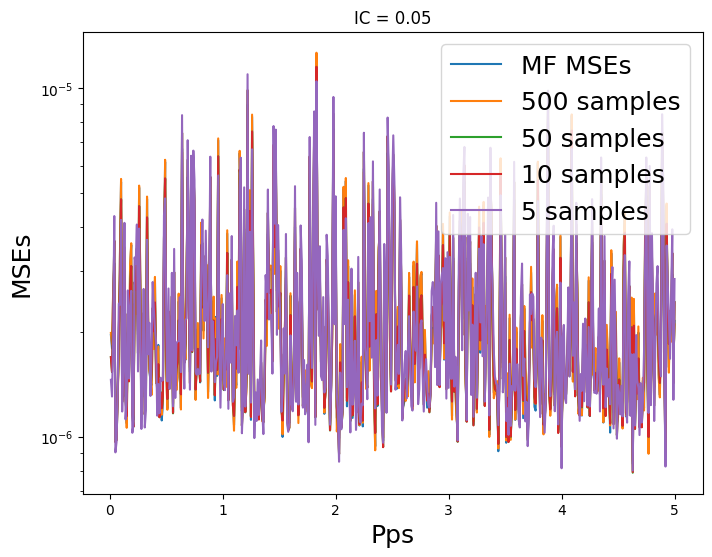

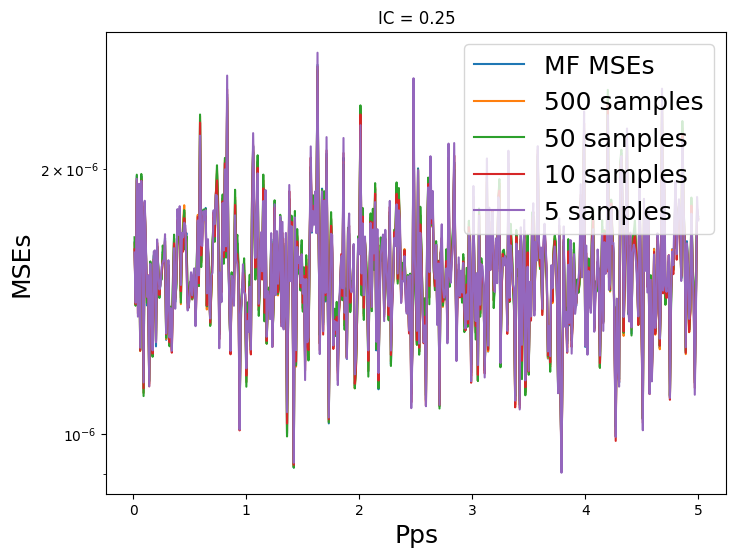

In [29]:
data_type = "mean_field_lessnoise"#"ABM"#,"mean_field_nonoise","mean_field_lessnoise"

param_degree = 1
C_degree = 10

fontsize = 18

ICs = [0.05, 0.25]
drps = [0.01, 0.1, 0.5, 1]

for IC in ICs:

    ### Get all data
    if data_type == "ABM":
        
        allFiles = []
        for rp in np.arange(0.01,5.01,0.01):
            rd = rp/2
            rp,rd = format_rp_rd(rp,rd)

            allFiles.append(f"../../data/ABM/logistic_ABM_sim_rp_{rp:.2f}_rd_{rd}_rm_1_m_{IC}_real25.npy")
    
    elif "mean_field" in data_type:
        
        allFiles = []
        for rp in np.arange(0.01,5.01,0.01):
            rd = rp/2
            rp,rd = format_rp_rd(rp,rd)

            allFiles.append(f"../../data/Data_{data_type}/gen_mfld_data_rp_{rp:.2f}_rd_{rd}_rm_1_m_{IC}.npy")
        
    allFiles.sort()

    CDs, ts, Pps = tensor_data_build(allFiles)

    Pps.sort()

    MFs = tensor_model_build(CDs,ts,Pps,[np.array([0.5,-1])],
                np.array([1,1]),np.array([1,2]))

    MF_MSEs = []
    for i in range(len(Pps)):
        MF_MSEs.append(MSE(CDs[i,:], MFs[i,:]))
    MF_MSEs = np.array(MF_MSEs)

    plt.figure(figsize=(8,6))
    plt.semilogy(Pps, MF_MSEs, label = "MF MSEs")

    for drp in drps:

        mat = np.load(f"../../results/ES-MEEQL/learned_coeffs_{data_type}_param_degree_{param_degree}_C_degree_{C_degree}_IC_{IC}_drp_{drp}.npy",
                     allow_pickle=True).item()

        xi = mat["xi"]
        learned_C_degrees = mat["learned_C_degrees"]
        learned_param_degrees = mat["learned_param_degrees"]

        CMs = tensor_model_build(CDs,ts,Pps,[xi],
                learned_param_degrees,learned_C_degrees)

        learned_MSEs = []
        for i in range(len(Pps)):
            learned_MSEs.append(MSE(CDs[i,:], CMs[i,:]))
        learned_MSEs = np.array(learned_MSEs)

        num_samples = int(5/drp)

        plt.semilogy(Pps, learned_MSEs, label = f"{num_samples} samples")
    plt.legend(fontsize=fontsize)
    plt.title(f"IC = {IC}")
    plt.xlabel(f"Pps",fontsize=fontsize)
    plt.ylabel(f"MSEs",fontsize=fontsize)

    plt.savefig(f"MSEs_{data_type}_IC_{IC}.png")

In [25]:
ICs = [0.05, 0.25]
drps = [0.01, 0.5, 1]

data_type = "ABM"

for IC in ICs:
    print(f"IC = {IC}\n")
        
    for drp in drps:

        mat = np.load(f"../../results/ES-MEEQL/learned_coeffs_{data_type}_param_degree_{param_degree}_C_degree_{C_degree}_IC_{IC}_drp_{drp}.npy",
                     allow_pickle=True).item()

        xi = mat["xi"]
        learned_C_degrees = mat["learned_C_degrees"]
        learned_param_degrees = mat["learned_param_degrees"]

        num_samples = int(5/drp)
        
        print(f"{num_samples} samples:")
        print_DE(xi,learned_param_degrees,learned_C_degrees)
        print("")
        
        

IC = 0.05

500 samples:
0.36*P_p^1*C^1 - 2.34*P_p^1*C^2 + 5.6*P_p^1*C^3 - 5.0*P_p^1*C^4

10 samples:
0.4*P_p^1*C^1 - 2.53*P_p^1*C^2 + 5.81*P_p^1*C^3 - 4.92*P_p^1*C^4

5 samples:
0.42*P_p^1*C^1 - 2.37*P_p^1*C^2 + 3.92*P_p^1*C^3 - 3.84*P_p^1*C^5

IC = 0.25

500 samples:
0.34*P_p^1*C^1 - 0.85*P_p^1*C^2

10 samples:
0.85*P_p^1*C^1 - 2.95*P_p^1*C^2 + 5.24*P_p^1*C^4

5 samples:
0.86*P_p^1*C^1 - 2.92*P_p^1*C^2 + 4.94*P_p^1*C^4



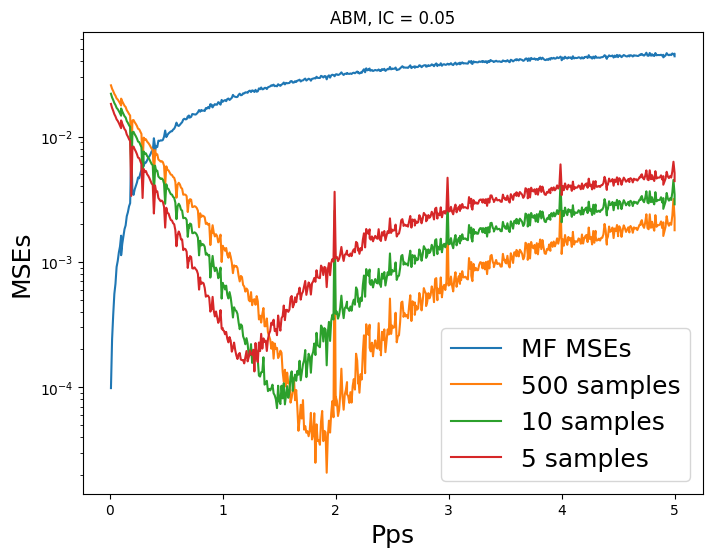

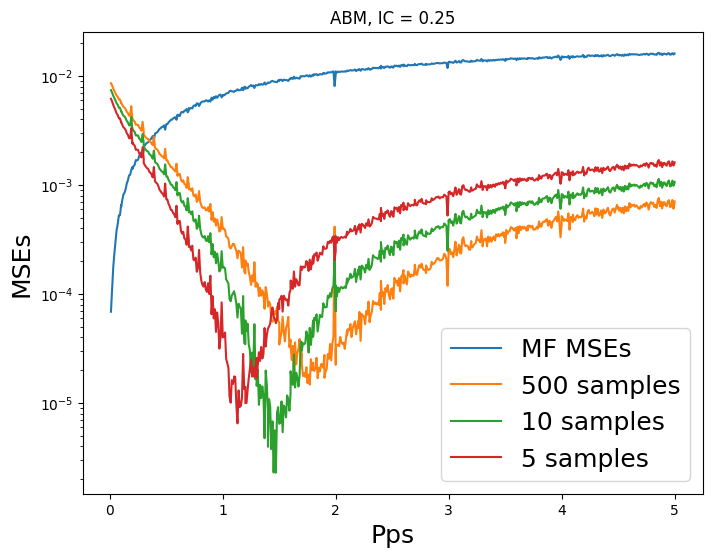

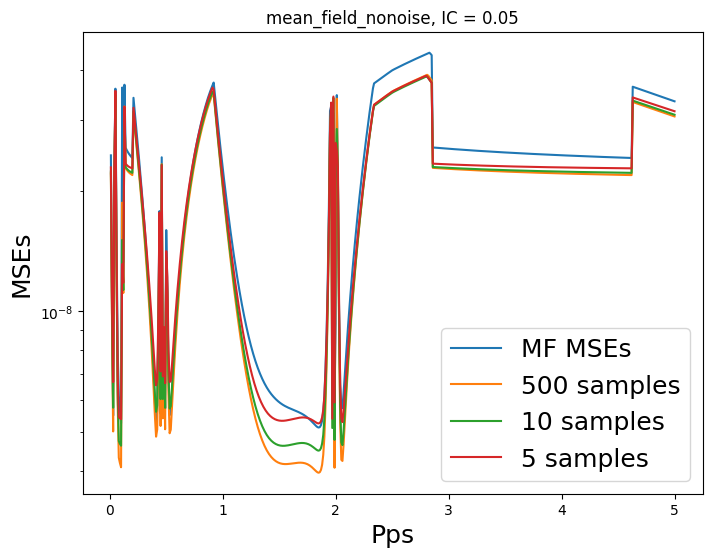

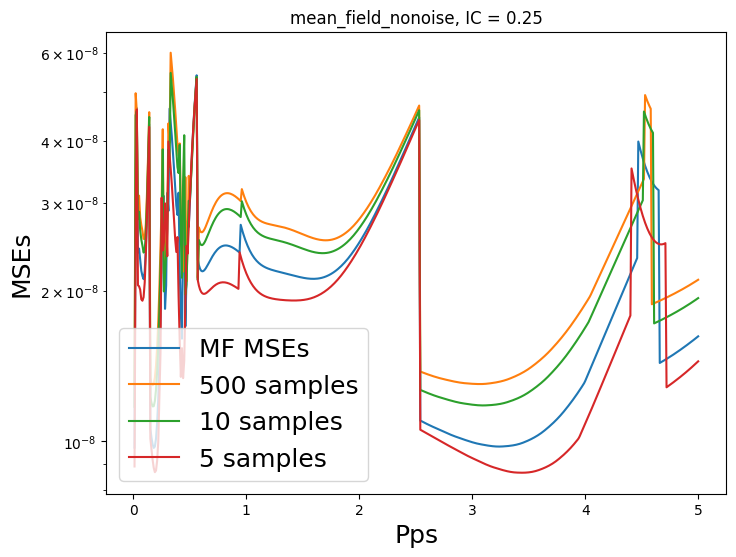

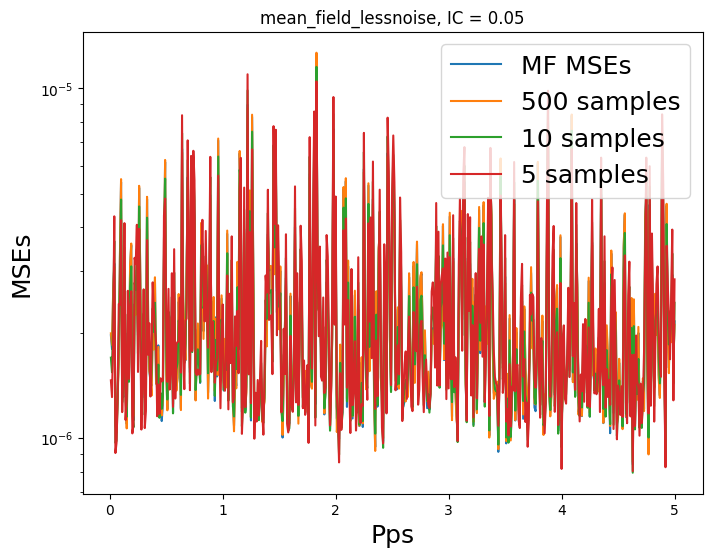

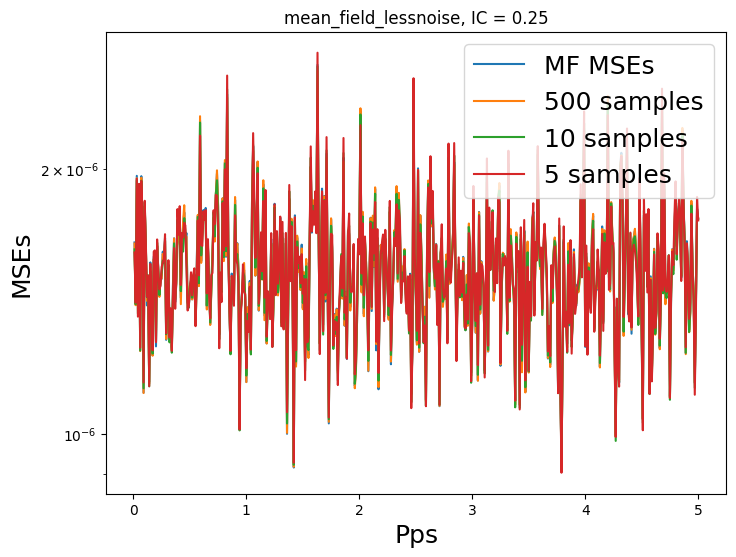

In [26]:
data_types = ["ABM",
              "mean_field_nonoise",
              "mean_field_lessnoise"]

param_degree = 1
C_degree = 10
fontsize = 18

all_MSEs = {}
drps = [0.01, 0.5, 1]

for data_type in data_types:

    all_MSEs[data_type] = {}
    
    ICs = [0.05, 0.25]

    for IC in ICs:

        all_MSEs[data_type][IC] = {}
        
        ### Get all data
        if data_type == "ABM":
            allFiles = glob.glob(f"../../data/ABM/*m_{IC}*.npy")
        elif "mean_field" in data_type:
            allFiles = glob.glob(f"../../data/Data_{data_type}/*m_{IC}*.npy")
        allFiles.sort()
        
        CDs, ts, Pps = tensor_data_build(allFiles)

        Pps.sort()

        MFs = tensor_model_build(CDs,ts,Pps,[np.array([0.5,-1])],
                    np.array([1,1]),np.array([1,2]))

        MF_MSEs = []
        for i in range(len(Pps)):
            MF_MSEs.append(MSE(CDs[i,:], MFs[i,:]))
        MF_MSEs = np.array(MF_MSEs)

        plt.figure(figsize=(8,6))
        plt.semilogy(Pps, MF_MSEs, label = "MF MSEs")
        all_MSEs[data_type][IC]["mean_field"] = MF_MSEs
        
        for drp in drps:

            mat = np.load(f"../../results/ES-MEEQL/learned_coeffs_{data_type}_param_degree_{param_degree}_C_degree_{C_degree}_IC_{IC}_drp_{drp}.npy",
                         allow_pickle=True).item()

            xi = mat["xi"]
            learned_C_degrees = mat["learned_C_degrees"]
            learned_param_degrees = mat["learned_param_degrees"]

            CMs = tensor_model_build(CDs,ts,Pps,[xi],
                    learned_param_degrees,learned_C_degrees)

            learned_MSEs = []
            for i in range(len(Pps)):
                learned_MSEs.append(MSE(CDs[i,:], CMs[i,:]))
            learned_MSEs = np.array(learned_MSEs)

            num_samples = int(5/drp)

            all_MSEs[data_type][IC][num_samples] = learned_MSEs
            
            plt.semilogy(Pps, learned_MSEs, label = f"{num_samples} samples")
        plt.legend(fontsize=fontsize)
        plt.title(f"{data_type}, IC = {IC}")
        plt.xlabel(f"Pps",fontsize=fontsize)
        plt.ylabel(f"MSEs",fontsize=fontsize)

        # plt.savefig(f"MSEs_{data_type}_IC_{IC}_param_degree_{param_degree}_C_degree_{C_degree}.png")

# np.save(f"../../results/ES-MEEQL/learned_MSEs_param_degree_{param_degree}_C_degree_{C_degree}.npy",all_MSEs)